In [10]:
import numpy as np
from keras.models import Model, load_model
from keras.layers import Dense,BatchNormalization,Conv1D
from keras.layers import Input,GlobalMaxPooling1D,concatenate
from keras.optimizers import Adam
from utils import generate, generate_sim, OrnsteinUng
import tensorflow as tf
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
import datetime
from keras.callbacks import History 
import matplotlib.pyplot as plt
import pickle
import glob
import os

[(10, 0.668749988079071), (15, 0.7281249761581421), (20, 0.7562500238418579), (30, 0.800000011920929), (31, 0.78125), (32, 0.793749988079071), (33, 0.796875), (34, 0.800000011920929), (35, 0.8125), (40, 0.8343750238418579), (49, 0.831250011920929), (50, 0.8218749761581421), (51, 0.84375), (60, 0.862500011920929), (70, 0.815625011920929), (80, 0.8812500238418579), (90, 0.878125011920929), (100, 0.859375), (300, 0.940625011920929)]
[10, 15, 20, 30, 31, 32, 33, 34, 35, 40, 49, 50, 51, 60, 70, 80, 90, 100, 300]
[0.668749988079071, 0.7281249761581421, 0.7562500238418579, 0.800000011920929, 0.78125, 0.793749988079071, 0.796875, 0.800000011920929, 0.8125, 0.8343750238418579, 0.831250011920929, 0.8218749761581421, 0.84375, 0.862500011920929, 0.815625011920929, 0.8812500238418579, 0.878125011920929, 0.859375, 0.940625011920929]


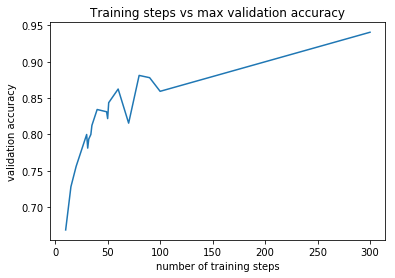

In [39]:
plt.figure()
sizes = []
max_val_acc = []

dir_path = os.getcwd()
matching_files = glob.glob( dir_path +"\*_history*")

for file in matching_files:
    with open(file, 'rb') as handle:
        history = pickle.loads(handle.read())
        train_loss = history['loss']
        val_loss   = history['val_loss']
        train_acc  = history['acc']
        val_acc    = history['val_acc']
        
        max_val_acc.append(max(val_acc))
    string = [s for s in file if s.isdigit()]
    actualstring = ""
    for s in string:
        actualstring += s
    sizes.append(int(actualstring))
zipped = zip(sizes, max_val_acc)
sorted_pairs = sorted(zipped)
sizes = [sorted_pairs[i][0] for i in range(len(sorted_pairs))]
max_val_acc = [sorted_pairs[i][1] for i in range(len(sorted_pairs))]

print(sorted_pairs)
print(sizes)
print(max_val_acc)
plt.xlabel("number of training steps")
plt.ylabel("validation accuracy")
plt.title("Training steps vs max validation accuracy")
plt.plot(sizes, max_val_acc)

#         plt.plot(xc, val_loss, label="validation loss")
#         plt.legend()

In [22]:
def classification_on_sim(net_file, num_steps):
    dx,label=generate_sim(batchsize=100,steps=num_steps,T=15,sigma=0.00)
    ### change here to load a different network model
    print(dx)
    N=np.shape(dx)[0]
#     net_file = './Models/model_testsigma0-wB-6layern-300-variance-FBMCTRW.h5'
    model = load_model(net_file)
    predictions = []
    for j in range(N):
        dummy = np.zeros((1,num_steps-1,1))
        dummy[0,:,:] = dx[j,:,:]
        y_pred = model.predict(dummy) # get the results for 1D 
        print(y_pred)
        ymean = np.mean(y_pred,axis=0) # calculate mean prediction of N-dimensional trajectory 
        prediction = np.argmax(ymean,axis=0) # translate to classification
        predictions.append(prediction)

    accuracy = 100 * np.sum([1 if label[i] == predictions[i] else 0 for i in range(len(label))]) / len(label)
    return accuracy


In [23]:
accuracies = []
# for i in range(10, 101, 10):
accuracies.append(classification_on_sim('./Models/300_model.h5', 300))
print(accuracies)

[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.        ]
  [ 0.10077603]
  [ 1.01492113]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[-2.33335373]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 ...

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[-0.3988092 ]
  [ 0.40503002]
  [-0.43279118]
  ...
  [ 0.27990043]
  [-0.27671639]
  [ 0.50046888]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]]
[[0.18749148 0.33819774 0.47431076]]
[[0.00462613 0.02028624 0.97508764]]
[[0.00185184 0.00700784 0.9911403 ]]
[[0.18749148 0.33819774 0.47431076]]
[[0.43998116 0.52153945 0.03847945]]
[[0.18749148 0.33819774 0.47431076]]
[[0.52524626 0.42791384 0.04683989]]
[[0.40487963 0.39813885 0.19698149]]
[[0.18749148 0.33819774 0.47431076]]
[[0.3541185  0.51471114 0.13117042]]


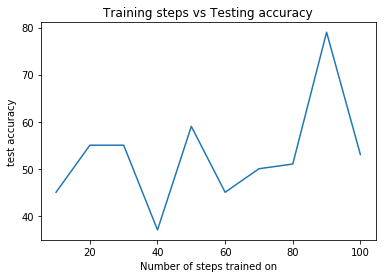

In [9]:
plt.xlabel("Number of steps trained on")
plt.ylabel("test accuracy")
plt.title("Training steps vs Testing accuracy")
plt.plot(range(10, 101, 10),accuracies)
